## Hey There!
Modeling Approach: 1D Convolutional Neural Network  

# Set up

In [ ]:
# @title Imports 
import pandas as pd
import numpy as np

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.metrics import AUC
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random
import os
import json



import matplotlib.pyplot as plt
from IPython.display import clear_output 

pd.set_option('display.max_columns', None)

Connect to TPU

In [ ]:
## Connect to TPU ##

# TPU Configuration
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

with tf.device('/TPU:0'):
  c = tf.matmul(a, b)
print("c device: ", c.device)
print(c)
strategy = tf.distribute.TPUStrategy(resolver)

# Clear ouput 
clear_output()

In [ ]:
# Connect to Drive 
from google.colab import drive
drive.mount('/content/drive')
clear_output()

#Data Preprocessing / Normalization 

Get and Preprocess X

In [ ]:
#Load data
Wide_X = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Sleep Disorder Project/Project Code + Data/Minute-by-Minute Data/Wide Data [Smoothed]/wideX_Smoothed.pkl')
#Wide_X = Wide_X.drop("Unnamed: 0", axis = 1)

#Wide_X.fillna(0)
Wide_X = Wide_X.where(Wide_X > 0.0000001, 0)

In [ ]:
Wide_X

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Seperate SEQN from dataframe
SEQN = Wide_X.pop("SEQN")
data_wide = Wide_X

# Normalize from 0.01 to 1
scaler = MinMaxScaler()
scaler.fit(data_wide)
data_wide = scaler.transform(data_wide)

# Convert DF to array
data_wide = np.array(data_wide)

# Set 3-D shape
data_wide = data_wide.reshape(len(data_wide),len(data_wide[0]),1)
data_wide = data_wide.astype(np.float32)
# Set shape for model
data_wide_shape = (data_wide.shape[1],data_wide.shape[2])



print("Shape:", data_wide.shape)

Shape: (5429, 10080, 1)


Preprocess y

In [ ]:
# Load Data Y ----
Y = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Sleep Disorder Project/Project Code + Data/Minute-by-Minute Data/Wide Data [Smoothed]/y.pkl')
#Y = Y.drop("Unnamed: 0", axis = 1)
#Make y array as well 
y = np.hstack(np.asarray(Y)).reshape(len(Y),1)
print(y.shape)
y = y.astype(np.float32)

(5429, 1)


### Stratified Train Test Split

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(data_wide, y, SEQN, test_size=0.2, stratify = y, random_state = 41)

# Train Validation Split
X_trainB, X_valB, y_trainB, y_valB, ids_trainB, ids_valB = train_test_split(X_train, y_train, ids_train, test_size=0.2, stratify = y_train, random_state = 32)

# Modeling!

Make Model

In [ ]:
#Make Model 
def create_model():
  model = tf.keras.Sequential()
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(10080, 1)))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.2))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  return model

Compile Model 

In [ ]:
from keras import optimizers

# Compile Model 
with strategy.scope():
  model = create_model()
  model.compile(
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
  optimizer= tf.keras.optimizers.Adam(),
  metrics= tf.keras.metrics.AUC(name="auc")
)

In [ ]:
# Save Model 
model.save_weights("reset_weights.h5")

def reset_model():
  model.load_weights("reset_weights.h5")

## Model Visuals

In [ ]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10078, 64)         256       
                                                                 
 conv1d_1 (Conv1D)           (None, 10076, 64)         12352     
                                                                 
 dropout (Dropout)           (None, 10076, 64)         0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5038, 64)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 322432)            0         
                                                                 
 dense (Dense)               (None, 100)               32243300  
                                                        

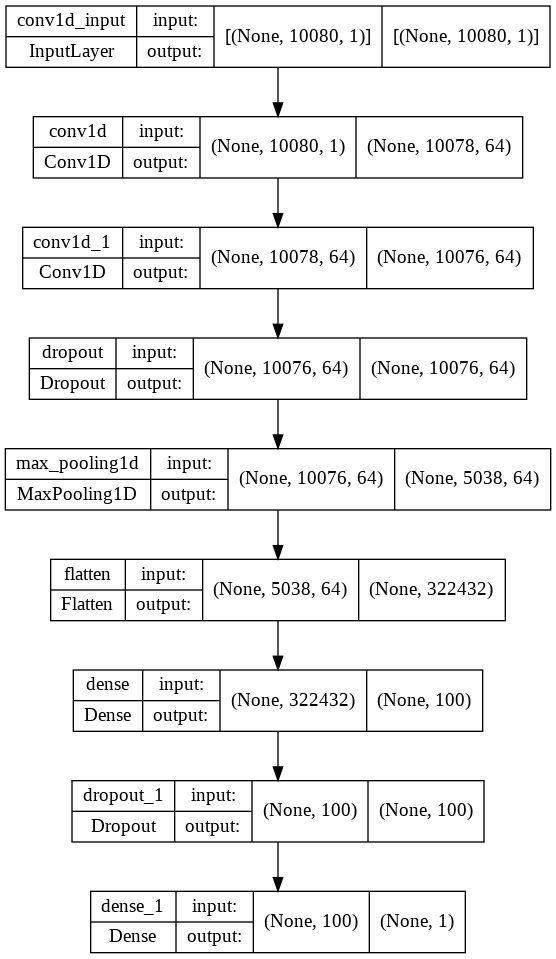

In [ ]:
# Plot Model Architecture 
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

##Train Model 

In [ ]:
## Parameters##

# Save Best Weights 
filepath = "VAL-AUC-impr(fr).h5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath, #=checkpoint_filepath,
    verbose = 1,
    monitor='val_auc',
    mode='max',
    save_best_only=True)


# Balance Weights 
n_sd = sum(y)
n_no_sd = len(y) - n_sd
class_weights = {0: (n_no_sd/len(y)),                # Custom Setting Class Weights 
                1: (n_sd/len(y))}

In [ ]:
# Fit model                                              
tf.keras.backend.clear_session()
history = model.fit(
    X_trainB, y_trainB,
    validation_data=(X_valB, y_valB),
    epochs=20, 
    batch_size= 64, # Change size 
    shuffle=False,
    verbose = 1,
    class_weight=class_weights,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/20
55/55 [==============================] - ETA: 0s - loss: 0.0615 - auc: 0.5630
Epoch 1: val_auc improved from -inf to 0.64469, saving model to VAL-AUC-impr(fr).h5
55/55 [==============================] - 27s 315ms/step - loss: 0.0615 - auc: 0.5630 - val_loss: 0.3115 - val_auc: 0.6447
Epoch 2/20
55/55 [==============================] - ETA: 0s - loss: 0.0477 - auc: 0.6182
Epoch 2: val_auc improved from 0.64469 to 0.64857, saving model to VAL-AUC-impr(fr).h5
55/55 [==============================] - 5s 83ms/step - loss: 0.0477 - auc: 0.6182 - val_loss: 0.3095 - val_auc: 0.6486
Epoch 3/20
55/55 [==============================] - ETA: 0s - loss: 0.0473 - auc: 0.6318
Epoch 3: val_auc did not improve from 0.64857
55/55 [==============================] - 3s 48ms/step - loss: 0.0473 - auc: 0.6318 - val_loss: 0.3087 - val_auc: 0.6387
Epoch 4/20
55/55 [==============================] - ETA: 0s - loss: 0.0465 - auc: 0.6634
Epoch 4: val_auc did not improve from 0.64857
55/55 [============

## Graphing

Evaulate 

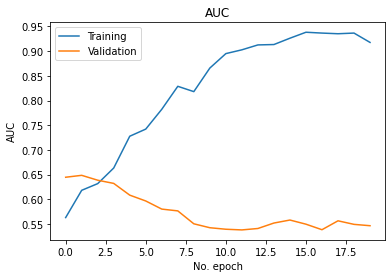

<Figure size 432x288 with 0 Axes>

In [ ]:
history_df = pd.DataFrame({'auc':history.history['auc'], 'val_auc':history.history['val_auc']})
history_df.to_csv("history_df.csv", index = False)

# Plot history: AUC
plt.plot(history_df['auc'], label='Training')
plt.plot(history_df['val_auc'], label='Validation')
plt.title('AUC')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()
plt.savefig('')

17/17 [==============================] - 1s 44ms/step - loss: 0.3082 - auc: 0.6736
--------------------------
Keras Model Loading Test AUC: 0.67
--------------------------
SKLearn Test AUC: 0.676
--------------------------


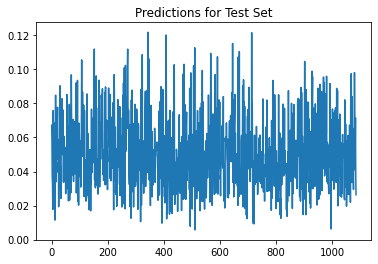

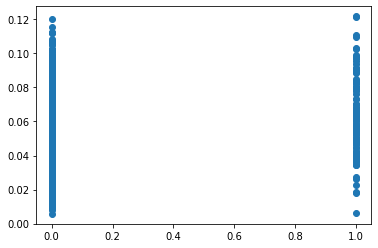

In [ ]:
# Evaluate 
model.evaluate(X_test, y_test, batch_size = 64)
#Keras Test AUC
from keras.models import load_model
test_set_model = keras.models.load_model('VAL-AUC-impr(fr).h5')
results = test_set_model.evaluate(X_test, y_test, batch_size = 64)
print("--------------------------")
print(f'Keras Model Loading Test AUC: {round(results[1],2)}')
print("--------------------------")


#SKLearn Test AUC 
preds = test_set_model.predict(X_test)
from sklearn.metrics import r2_score, roc_auc_score
print(f'SKLearn Test AUC: {round(roc_auc_score(y_test, preds),3)}')
print("--------------------------")
plt.plot(preds)
plt.title('Predictions for Test Set')
plt.show()
plt.scatter(y_test, preds)

In [ ]:
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc(filepath, X_test, y_test):
  test_set_model = keras.models.load_model(filepath)
  # NO skill
  ns_probs = [0 for _ in range(len(y_test))]
  # predict probabilities
  lr_probs = test_set_model.predict(X_test)
  # keep probabilities for the positive outcome only
  #lr_probs = lr_probs[:, 1]
  # calculate scores
  ns_auc = roc_auc_score(y_test, ns_probs)
  lr_auc = roc_auc_score(y_test, lr_probs)
  # summarize scores
  print('No Skill: ROC AUC=%.3f' % (ns_auc))
  print('1d_CNN: ROC AUC=%.3f' % (lr_auc))
  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
  # plot the roc curve for the model
  pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
  pyplot.plot(lr_fpr, lr_tpr, marker='.', label='1D CNN', color='midnightblue')
  # axis labels
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  # show the legend
  pyplot.legend()
  # show the plot
  pyplot.show()

plot_roc('VAL-AUC-impr(fr).h5', X_test, y_test)

#K-Fold Cross Validation

Resetting model..
Epoch 1/20
109/109 [==============================] - ETA: 0s - loss: 0.0640 - auc: 0.5420
Epoch 1: val_auc improved from -inf to 0.64879, saving model to VAL-AUC-impr(fr)1.h5
109/109 [==============================] - 16s 97ms/step - loss: 0.0640 - auc: 0.5420 - val_loss: 0.3346 - val_auc: 0.6488
Epoch 2/20
108/109 [============================>.] - ETA: 0s - loss: 0.0485 - auc: 0.6042
Epoch 2: val_auc did not improve from 0.64879
109/109 [==============================] - 4s 40ms/step - loss: 0.0485 - auc: 0.6035 - val_loss: 0.3361 - val_auc: 0.6415
Epoch 3/20
109/109 [==============================] - ETA: 0s - loss: 0.0477 - auc: 0.6242
Epoch 3: val_auc did not improve from 0.64879
109/109 [==============================] - 4s 40ms/step - loss: 0.0477 - auc: 0.6242 - val_loss: 0.3380 - val_auc: 0.6421
Epoch 4/20
109/109 [==============================] - ETA: 0s - loss: 0.0470 - auc: 0.6464
Epoch 4: val_auc did not improve from 0.64879
109/109 [===================

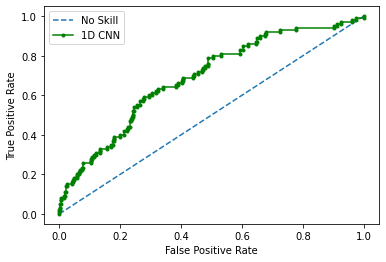

 
-
-
-
-
-
-
-
-
-
val set:
14/14 [==============================] - 1s 42ms/step - loss: 0.3348 - auc: 0.6479
No Skill: ROC AUC=0.500
1d_CNN: ROC AUC=0.649


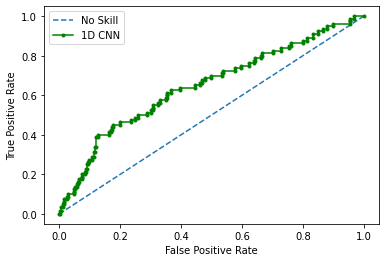

Saving model...
Saving files...
FINISHED CYCLE NUMBER: 1
Resetting model..
Epoch 1/20
109/109 [==============================] - ETA: 0s - loss: 0.0628 - auc: 0.5580
Epoch 1: val_auc improved from -inf to 0.64435, saving model to VAL-AUC-impr(fr)2.h5
109/109 [==============================] - 6s 60ms/step - loss: 0.0628 - auc: 0.5580 - val_loss: 0.3428 - val_auc: 0.6443
Epoch 2/20
109/109 [==============================] - ETA: 0s - loss: 0.0483 - auc: 0.6029
Epoch 2: val_auc did not improve from 0.64435
109/109 [==============================] - 4s 39ms/step - loss: 0.0483 - auc: 0.6029 - val_loss: 0.3465 - val_auc: 0.6379
Epoch 3/20
109/109 [==============================] - ETA: 0s - loss: 0.0468 - auc: 0.6484
Epoch 3: val_auc improved from 0.64435 to 0.65221, saving model to VAL-AUC-impr(fr)2.h5
109/109 [==============================] - 6s 58ms/step - loss: 0.0468 - auc: 0.6484 - val_loss: 0.3458 - val_auc: 0.6522
Epoch 4/20
109/109 [==============================] - ETA: 0s - los

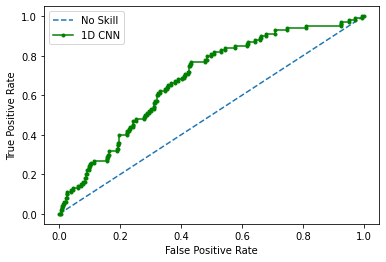

 
-
-
-
-
-
-
-
-
-
val set:
14/14 [==============================] - 1s 42ms/step - loss: 0.3458 - auc: 0.6524
No Skill: ROC AUC=0.500
1d_CNN: ROC AUC=0.656


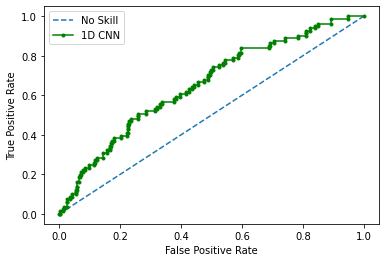

Saving model...
Saving files...
FINISHED CYCLE NUMBER: 2
Resetting model..
Epoch 1/20
109/109 [==============================] - ETA: 0s - loss: 0.0612 - auc: 0.5629
Epoch 1: val_auc improved from -inf to 0.63241, saving model to VAL-AUC-impr(fr)3.h5
109/109 [==============================] - 7s 60ms/step - loss: 0.0612 - auc: 0.5629 - val_loss: 0.3856 - val_auc: 0.6324
Epoch 2/20
109/109 [==============================] - ETA: 0s - loss: 0.0481 - auc: 0.6235
Epoch 2: val_auc did not improve from 0.63241
109/109 [==============================] - 4s 40ms/step - loss: 0.0481 - auc: 0.6235 - val_loss: 0.3763 - val_auc: 0.6260
Epoch 3/20
109/109 [==============================] - ETA: 0s - loss: 0.0479 - auc: 0.6358
Epoch 3: val_auc did not improve from 0.63241
109/109 [==============================] - 4s 39ms/step - loss: 0.0479 - auc: 0.6358 - val_loss: 0.3663 - val_auc: 0.6183
Epoch 4/20
109/109 [==============================] - ETA: 0s - loss: 0.0468 - auc: 0.6638
Epoch 4: val_auc d

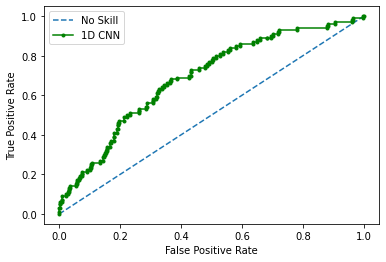

 
-
-
-
-
-
-
-
-
-
val set:
14/14 [==============================] - 1s 44ms/step - loss: 0.3855 - auc: 0.6319
No Skill: ROC AUC=0.500
1d_CNN: ROC AUC=0.630


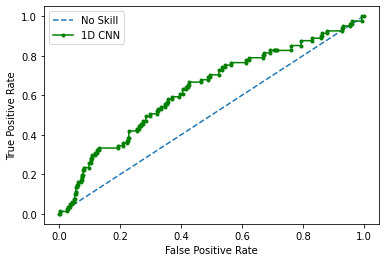

Saving model...
Saving files...
FINISHED CYCLE NUMBER: 3
Resetting model..
Epoch 1/20
109/109 [==============================] - ETA: 0s - loss: 0.0623 - auc: 0.5306
Epoch 1: val_auc improved from -inf to 0.62688, saving model to VAL-AUC-impr(fr)4.h5
109/109 [==============================] - 7s 61ms/step - loss: 0.0623 - auc: 0.5306 - val_loss: 0.3288 - val_auc: 0.6269
Epoch 2/20
109/109 [==============================] - ETA: 0s - loss: 0.0500 - auc: 0.5506
Epoch 2: val_auc did not improve from 0.62688
109/109 [==============================] - 4s 40ms/step - loss: 0.0500 - auc: 0.5506 - val_loss: 0.3308 - val_auc: 0.6218
Epoch 3/20
109/109 [==============================] - ETA: 0s - loss: 0.0486 - auc: 0.6019
Epoch 3: val_auc did not improve from 0.62688
109/109 [==============================] - 4s 41ms/step - loss: 0.0486 - auc: 0.6019 - val_loss: 0.3293 - val_auc: 0.6140
Epoch 4/20
109/109 [==============================] - ETA: 0s - loss: 0.0484 - auc: 0.6138
Epoch 4: val_auc i

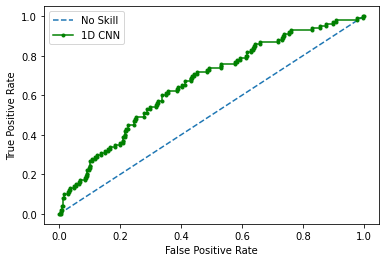

 
-
-
-
-
-
-
-
-
-
val set:
14/14 [==============================] - 1s 41ms/step - loss: 0.3273 - auc: 0.6267
No Skill: ROC AUC=0.500
1d_CNN: ROC AUC=0.623


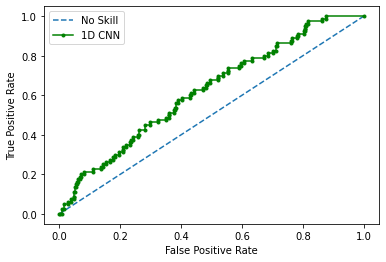

Saving model...
Saving files...
FINISHED CYCLE NUMBER: 4
Resetting model..
Epoch 1/20
108/109 [============================>.] - ETA: 0s - loss: 0.0587 - auc: 0.5495
Epoch 1: val_auc improved from -inf to 0.63633, saving model to VAL-AUC-impr(fr)5.h5
109/109 [==============================] - 8s 72ms/step - loss: 0.0588 - auc: 0.5482 - val_loss: 0.3678 - val_auc: 0.6363
Epoch 2/20
109/109 [==============================] - ETA: 0s - loss: 0.0489 - auc: 0.5957
Epoch 2: val_auc did not improve from 0.63633
109/109 [==============================] - 4s 41ms/step - loss: 0.0489 - auc: 0.5957 - val_loss: 0.3597 - val_auc: 0.6361
Epoch 3/20
109/109 [==============================] - ETA: 0s - loss: 0.0481 - auc: 0.6357
Epoch 3: val_auc improved from 0.63633 to 0.63665, saving model to VAL-AUC-impr(fr)5.h5
109/109 [==============================] - 6s 59ms/step - loss: 0.0481 - auc: 0.6357 - val_loss: 0.3386 - val_auc: 0.6367
Epoch 4/20
109/109 [==============================] - ETA: 0s - los

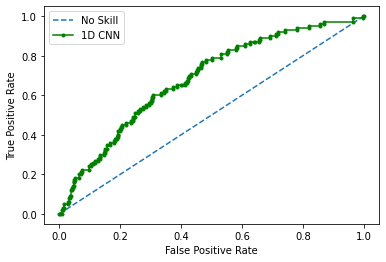

 
-
-
-
-
-
-
-
-
-
val set:
14/14 [==============================] - 1s 41ms/step - loss: 0.3387 - auc: 0.6365
No Skill: ROC AUC=0.500
1d_CNN: ROC AUC=0.640


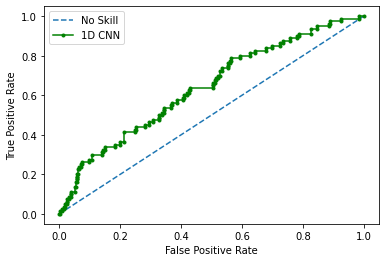

Saving model...
Saving files...
FINISHED CYCLE NUMBER: 5

CV Test AUC----------------------------
Individual scores: [0.6843001842498779, 0.6834026575088501, 0.6951318979263306, 0.6628499031066895, 0.6842191219329834]
Mean: 0.6819807529449463
std: 0.01050098947479783

CV Val AUC-----------------------------
Individual scores: [0.6478691101074219, 0.6523704528808594, 0.6318544149398804, 0.6267369985580444, 0.6364688873291016]
Mean: 0.6390599727630615
std: 0.00964633881060477
CPU times: user 3min 24s, sys: 56 s, total: 4min 20s
Wall time: 10min 28s


In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold

# Global Score List Buckets
cv_test_scores=[]
cv_val_scores=[]

# K fold parameters 
seed = 7
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# run K-fold 
count = 1
for train, val in kfold.split(X_train, y_train):
  
  # Create New Training Set 
  X_training = X_train[train]
  y_training = y_train[train]
  # Create new Validation Sets 
  X_val = X_train[val]
  y_val = y_train[val]

  # Reset model 
  print("Resetting model..")
  reset_model()
  # Checkpoints
  filepath = "VAL-AUC-impr(fr)" + str(count) +".h5"

  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath, #=checkpoint_filepath,
    verbose = 2,
    monitor='val_auc',
    mode='max',
    save_best_only=True)

  # fit model   
  tf.keras.backend.clear_session()
  history = model.fit(
      X_training, y_training,
      validation_data=(X_val, y_val),
      epochs=20, # Make Epochs larger
      batch_size= 32, # Change size 
      shuffle=False,
      verbose = 1,
      class_weight=class_weights,
      callbacks=[model_checkpoint_callback]
  )


 
  # Eval model 
  # model_eval()
  from keras.models import load_model
  test_set_model = keras.models.load_model(filepath)
  print(" \n-\n-\n-\n-\n-\n-\n-\n-\n-\ntest set:")
  scores = test_set_model.evaluate(X_test, y_test, batch_size=64) # Test Set
  cv_test_scores.append(scores[1])
  plot_roc(filepath,X_test, y_test)
  print(" \n-\n-\n-\n-\n-\n-\n-\n-\n-\nval set:")
  scores = test_set_model.evaluate(X_val, y_val, batch_size=64)  # Validation Set
  cv_val_scores.append(scores[1])
  plot_roc(filepath,X_val, y_val)



  # Save model 
  print("Saving model...")
  #save_model(count)
  # Save files
  print("Saving files...")
  #save_files(count)

  # increment 
  print("FINISHED CYCLE NUMBER:", count)
  count += 1 

# Score Eval
print("\nCV Test AUC----------------------------")
print("Individual scores:", cv_test_scores)
print("Mean:", np.mean(cv_test_scores))
print("std:", np.std(cv_test_scores))
print("\nCV Val AUC-----------------------------")
print("Individual scores:", cv_val_scores)
print("Mean:", np.mean(cv_val_scores))
print("std:", np.std(cv_val_scores))